<a href="https://colab.research.google.com/github/Mervvick/AI_ImageSegmentation_Lite/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%7C_%D0%94%D0%97_Lite_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

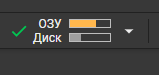



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

# Подготовка

### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:20<00:00, 10.2MB/s]


In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки
IMG_HEIGHT = 256              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.26c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.24c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100


# Решение


## Подготовка данных

In [ ]:
FLOOR = (100, 100, 100)
CEILING = (0, 0, 100)
WALL = (0, 100, 0)
COLUMN = (100, 0, 0)
APERTURE = (0, 100, 100)
DOOR = (100, 0, 100)
WINDOW = (100, 100, 0)
EXTERNAL = (200, 200, 200)
RAILINGS = (0, 200, 0)
BATTERY = (200, 0, 0)
PEOPLE = (0, 200, 200)
LADDER = (0, 0, 200)
INVENTORY = (200, 0, 200)
LAMP = (200, 200, 0)
WIRE = (0, 100, 200)
BEAM = (100, 0, 200)

In [ ]:
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

In [ ]:
def rgb_to_labels(image_list):

    result = []

    for d in image_list:
        sample = np.array(d)
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        for i, cl in enumerate(CLASS_LABELS):
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

In [ ]:
x_train = []
x_val = []

for img in train_images:
  x_train.append(image.img_to_array(img))
x_train = np.array(x_train)

for img in val_images:
  x_val.append(image.img_to_array(img))
x_val = np.array(x_val)

print(x_train.shape)
print(x_val.shape)

(1900, 192, 256, 3)
(100, 192, 256, 3)


In [ ]:
y_train = []
y_val = []

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


In [ ]:
y_train[(y_train > 2) & (y_train != 12)] = 3
y_train[y_train == 12] = 4

In [ ]:
y_val.max()

15

In [ ]:
y_val[(y_val > 2) & (y_val != 12)] = 3
y_val[y_val == 12] = 4

In [ ]:
y_val.max()

4

## Эксперементы

In [ ]:
def model_compile(input_shape, filter, kernel_size, activation, BLOCKS):

  input = Input(input_shape)
  x = input

  for block in range(BLOCKS):
    x = Conv2D(filter / (2 ** block) , kernel_size, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

  x = Conv2D(CLASS_COUNT, kernel_size, activation = 'softmax', padding='same')(x)

  model = Model(input, x)

  model.compile(optimizer = Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics = 'sparse_categorical_accuracy')

  return model

In [ ]:
# BLOCKS = 4
# EXPERIMENTS = 10

# filters = []
# kernels = []
# activations = []

# kernel = (random.choice(kernels_list), random.choice(kernels_list))
# for block in range(BLOCKS):
#   filters.append(32 * random.choice(multipliers_list))
#   activations.append(random.choice(activations_list))

# print(filters)
# print(kernel)
# print(activations)

In [ ]:
BLOCKS = 3
CLASS_COUNT = 5
BATCH_SIZE = 16
EPOCHS = 7

filters_list = (128, 64, 32)
kernels_list = ((2, 2), (3, 3))
activations_list = ('relu', 'linear')
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
history_list = []
data_list = []

num = 0
for activation in activations_list:
  for kernel_size in kernels_list:
    for filter in filters_list:
      num += 1
      model = model_compile(input_shape, filter, kernel_size, activation, 3)
      model.summary()
      history = model.fit(x_train,
                          y_train,
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          verbose = 1,
                          validation_data = (x_val, y_val)
                          )

      history_list.append(history)
      data_list.append(('num', num,
                       'activation:', activation,
                       'kernel_size', kernel_size,
                       'filter', filter,
                       'accuracy', history.history['sparse_categorical_accuracy'],
                       'val_accuracy', history.history['val_sparse_categorical_accuracy']
                       ))

      gc.collect()

      # plt.figure(figsize=(14, 7))
      # plt.plot(history.history['sparse_categorical_accuracy'])
      # plt.plot(history.history['val_sparse_categorical_accuracy'])
      # plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 192, 256, 128)     1664      
                                                                 
 batch_normalization_6 (Batc  (None, 192, 256, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 192, 256, 128)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 192, 256, 64)      32832     
                                                                 
 batch_normalization_7 (Batc  (None, 192, 256, 64)     256       
 hNormalization)                                           

In [ ]:
import pickle

In [ ]:
data = [history_list, data_list]
with open('data.pickle', 'wb') as f:
  pickle.dump(data, f)

In [ ]:
with open('data.pickle', 'rb') as f:
  data = pickle.load(f)
history_list, data_list = data

In [ ]:
i = 0
for line in data_list:
  data_list[i] = list(line)
  i += 1

In [ ]:
for line in data_list:
  line[9] = np.round(line[9], 2)
  line[9] = list(line[9])
  line[11] = np.round(line[11], 2)
  line[11] = list(line[11])

In [ ]:
for i in data_list:
  print(i[2:])

['activation:', 'relu', 'kernel_size', (2, 2), 'filter', 128, 'accuracy', [0.53, 0.55, 0.56, 0.57, 0.57, 0.58, 0.58], 'val_accuracy', [0.29, 0.43, 0.42, 0.45, 0.32, 0.36, 0.46]]
['activation:', 'relu', 'kernel_size', (2, 2), 'filter', 64, 'accuracy', [0.49, 0.54, 0.55, 0.56, 0.56, 0.57, 0.57], 'val_accuracy', [0.32, 0.43, 0.46, 0.47, 0.47, 0.34, 0.44]]
['activation:', 'relu', 'kernel_size', (2, 2), 'filter', 32, 'accuracy', [0.48, 0.54, 0.54, 0.54, 0.55, 0.56, 0.56], 'val_accuracy', [0.3, 0.47, 0.47, 0.37, 0.46, 0.47, 0.41]]
['activation:', 'relu', 'kernel_size', (3, 3), 'filter', 128, 'accuracy', [0.52, 0.56, 0.58, 0.59, 0.6, 0.6, 0.61], 'val_accuracy', [0.37, 0.42, 0.38, 0.36, 0.33, 0.26, 0.45]]
['activation:', 'relu', 'kernel_size', (3, 3), 'filter', 64, 'accuracy', [0.51, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6], 'val_accuracy', [0.34, 0.37, 0.34, 0.4, 0.31, 0.42, 0.3]]
['activation:', 'relu', 'kernel_size', (3, 3), 'filter', 32, 'accuracy', [0.47, 0.53, 0.54, 0.54, 0.55, 0.56, 0.56], 'v

In [ ]:
import pandas as pd
columns = [data_list[0][i] for i in range(2, 12, 2)]
columns

['activation:', 'kernel_size', 'filter', 'accuracy', 'val_accuracy']

In [ ]:
df = pd.DataFrame(columns = columns)
df['activation:'] = [line[3] for line in data_list]
df['kernel_size'] = [line[5] for line in data_list]
df['filter'] = [line[7] for line in data_list]
df['accuracy'] = [line[9][-1] for line in data_list]
df['val_accuracy'] = [line[11][-1] for line in data_list]
df

,activation:,kernel_size,filter,accuracy,val_accuracy
0,relu,"(2, 2)",128,0.58,0.46
1,relu,"(2, 2)",64,0.57,0.44
2,relu,"(2, 2)",32,0.56,0.41
3,relu,"(3, 3)",128,0.61,0.45
4,relu,"(3, 3)",64,0.60,0.30
5,relu,"(3, 3)",32,0.56,0.32
6,linear,"(2, 2)",128,0.52,0.47
7,linear,"(2, 2)",64,0.52,0.47
8,linear,"(2, 2)",32,0.52,0.47
9,linear,"(3, 3)",128,0.53,0.47
